<h1> Library yang digunakan

In [41]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import sklearn
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

<h1> Model

<h3> Inisialisasi array label dan features

In [29]:
features = []
label = []

<h3> Folder gambar

In [30]:
image_folder_path = "./images_folder"

<h3>  Cek jumlah isi konten folder

In [31]:
print(len(os.listdir(image_folder_path)))

## Atau

len(os.listdir(image_folder_path))

2


2

<h3> Dataset "Parasitized"

Proses yang dilakukan:
1. Masuk ke dalam folder "./images_folder/Parasitized"
2. Membaca semua file gambar yang ada di dalam folder tersebut
3. Mengubah colorspace gambar dari BGR ke RGB
4. Melakukan resize gambar menjadi 100x100 pixel
5. Menambahkan label "Parasitized" pada array label

In [32]:
parasitized_dir = os.path.join(image_folder_path, 'Parasitized')
for image_file in os.listdir(parasitized_dir):
    if image_file.endswith('.png'):
        image = cv2.imread(os.path.join(parasitized_dir, image_file))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        image = cv2.resize(image, (100, 100))
        features.append(image)
        label.append('Parasitized')


<h3> Dataset "Uninfected"

Proses yang dilakukan:
1. Masuk ke dalam folder "./images_folder/Uninfected"
2. Membaca semua file gambar yang ada di dalam folder tersebut
3. Mengubah colorspace gambar dari BGR ke RGB
4. Melakukan resize gambar menjadi 100x100 pixel
5. Menambahkan label "Parasitized" pada array label

In [33]:
uninfected_dir = os.path.join(image_folder_path, 'Uninfected')
for image_file in os.listdir(uninfected_dir):
    if image_file.endswith('.png'):
        image = cv2.imread(os.path.join(uninfected_dir, image_file))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (100, 100))
        features.append(image)
        label.append('Uninfected')

<h3> Ubah list features dan label menjadi NumPy array

In [34]:
X = np.array(features)
Y = np.array(label)
X = X.reshape(len(features), -1)

<h3> Split dataset

Bagi ukuran test dan train dengan rasio 0.1 <br>
randomisasi data dengan random_state=42

In [35]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

<h3> Ubah dimensi data features menjadi 1D (flatten)

In [36]:
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

<h3> Normalisasi data

In [37]:
x_train = x_train / 255.0
x_test = x_test / 255.0

<h1> Random Forest

<h2> Random Forest Classifier tanpa tuning

<h3> Inisialisasi Random Forest Classifier

Gunakan data train untuk training model

In [39]:
rf = RandomForestClassifier() 
rf.fit(x_train, y_train)

RandomForestClassifier()

<h3> Prediksi untuk train dan test

In [42]:
y_pred_train = rf.predict(x_train)
y_pred_test = rf.predict(x_test)

<h3> Confusion Matrix

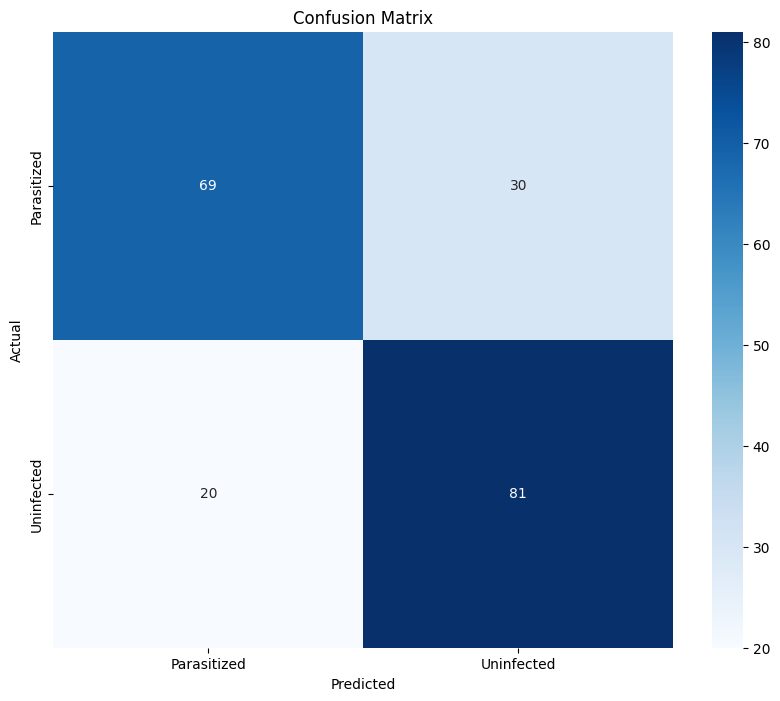

In [43]:
## 0 -> Parasitized, 1 -> Uninfected

cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Parasitized', 'Uninfected'], yticklabels=['Parasitized', 'Uninfected'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

<h3> Metriks untuk data training

In [44]:
print("Training metrics:")
print(sklearn.metrics.classification_report(y_true= y_train, y_pred= y_pred_train))

Training metrics:
              precision    recall  f1-score   support

 Parasitized       1.00      1.00      1.00       901
  Uninfected       1.00      1.00      1.00       899

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800



<h3> Metriks untuk data test

In [45]:
print("Test data metrics:")
print(sklearn.metrics.classification_report(y_true= y_test, y_pred= y_pred_test))

Test data metrics:
              precision    recall  f1-score   support

 Parasitized       0.78      0.70      0.73        99
  Uninfected       0.73      0.80      0.76       101

    accuracy                           0.75       200
   macro avg       0.75      0.75      0.75       200
weighted avg       0.75      0.75      0.75       200



<h2> Random Forest Classifier dengan parameter tuning

Akan di uji coba beberapa parameter untuk menentukan parameter yang terbaik

<h3> Parameter yang akan di uji coba

In [46]:
parameters = {  'n_estimators':[50,60,70,80,90,100],
                'min_samples_leaf':[1,2,3,4],
                'max_depth':[10,20,30],
                'max_features':[10,20,30,40,50],
                'criterion':['gini','entropy']
            }

<h3> Inisialisasi Random Forest Classifier

Insialisasi ditambah dengan fungsi GridSearchCV untuk mencari parameter terbaik

In [ ]:
rf = RandomForestClassifier()
rf = GridSearchCV(rf, param_grid=parameters, scoring='accuracy')
rf.fit(x_train, y_train)

Parameter terbaik yang akan digunakan

In [ ]:
best_params = rf.best_params_
print("Best Parameters:", best_params)

Didapat parameter terbaik sebagai berikut:
- criterion = 'gini'
- n_estimators = 100
- max_depth = 30
- min_samples_leaf = 2
- max_features = '30'

In [47]:
rf = RandomForestClassifier(n_estimators=100, criterion='gini' ,max_depth=30,  min_samples_leaf=2, max_features=30)
rf = rf.fit(x_train, y_train)

<h3> Prediksi untuk train dan test

In [48]:
y_pred_train = rf.predict(x_train)
y_pred_test = rf.predict(x_test)

<h3> Confusion Matrix

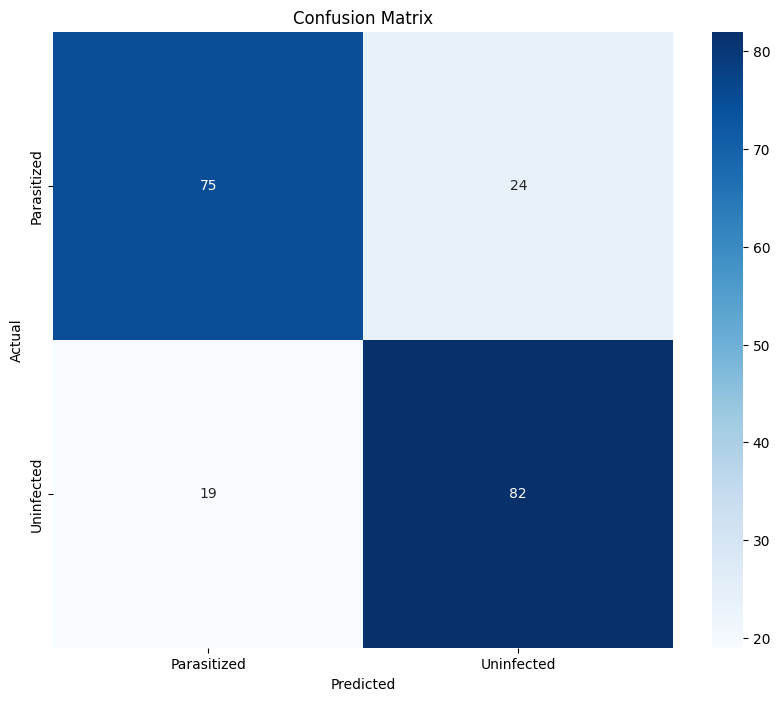

In [49]:
## 0 -> Parasitized, 1 -> Uninfected

cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Parasitized', 'Uninfected'], yticklabels=['Parasitized', 'Uninfected'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

<h3> Metriks untuk data training

In [50]:
print("Training metrics:")
print(sklearn.metrics.classification_report(y_true= y_train, y_pred= y_pred_train))

Training metrics:
              precision    recall  f1-score   support

 Parasitized       1.00      1.00      1.00       901
  Uninfected       1.00      1.00      1.00       899

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800



<h3> Metriks untuk data test

In [51]:
print("Test data metrics:")
print(sklearn.metrics.classification_report(y_true= y_test, y_pred= y_pred_test))

Test data metrics:
              precision    recall  f1-score   support

 Parasitized       0.80      0.76      0.78        99
  Uninfected       0.77      0.81      0.79       101

    accuracy                           0.79       200
   macro avg       0.79      0.78      0.78       200
weighted avg       0.79      0.79      0.78       200



<h1> Fungsi untuk klasifikasi gambar

In [ ]:
def test(img):
    resize_img = cv2.resize(img, (100, 100))
    array_image = np.array(resize_img)
    array_image = array_image.reshape(1, -1)

    print(rf.predict(array_image).reshape(1, -1))

    plt.imshow(array_image.reshape(100, 100, 3))    
    plt.show()

<h3> Memanggil fungsi

Dapat dilakukan di file yang sama atau yang berbeda <br>
Pada kasus ini, dilakukan pada file yang berbeda yaitu pada file bernama "input_img.py"

In [ ]:
import cv2
import matplotlib.pyplot as plt
from model import test
import os

img_path="images_test_run"

test_img_dir = os.path.join(img_path)
for image_file in os.listdir(test_img_dir):
    if image_file.endswith('.png'):
        image = cv2.imread(os.path.join(test_img_dir, image_file))
        plt.imshow(image)  
        plt.show() 
        print(image_file)
        test(image)